<a href="https://colab.research.google.com/github/GabrielaRomoM/SIGNALS-THEORY_2024-1/blob/main/ST_UMBRALADAPTATIVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scipy.signal import butter, filtfilt
from sklearn.preprocessing import MinMaxScaler

# Definición de las señales y calculo del PSD (Welch)

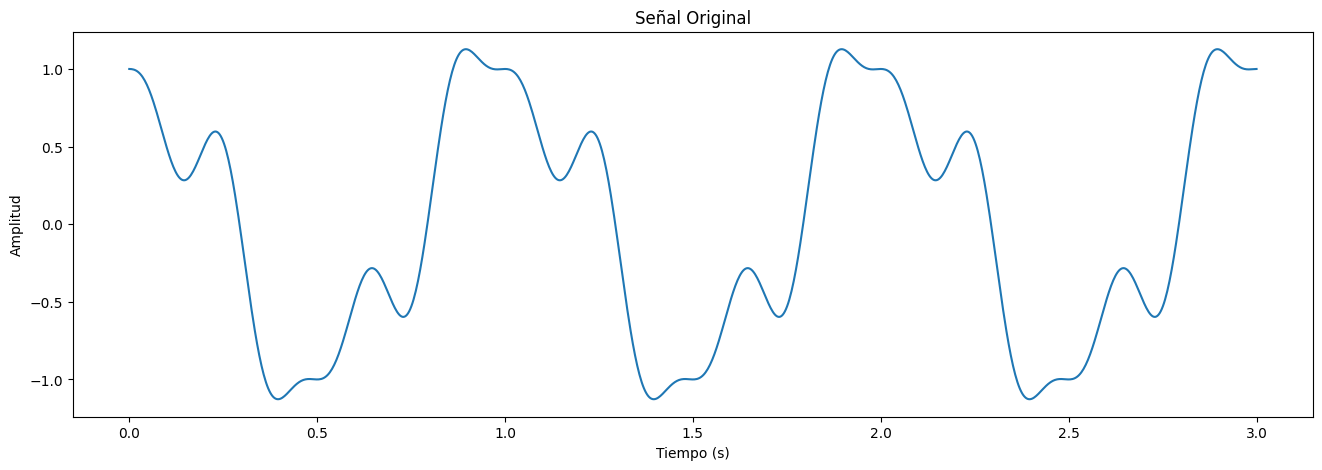

In [ ]:
#Frecuencia angular general y vector de tiempo
f = 1
w = 2*np.pi*f
T = 3
N = 1024 #puntos en la señal
fs= N/T #frecuencia de muestreo
t = np.linspace(0,T,N)

#Señales particulares
x1 = np.cos(w*t)
x2 = 1/3*(np.sin(3*w*t))
x3 = 1/5*(np.sin(5*w*t))

#Señal original para la red
xt = x1-x2+x3

plt.figure(figsize=(16,5))
plt.title('Señal Original')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,xt)
plt.show()

In [ ]:
#Generador de ruido blanco gausiano para crear la matriz con señales ruidosas
def generate_gaussian_noise(mean=0, stds=[0.1,0.3,1], size=1024, num_signals=340):
    R = []

    for std in stds:
      for i in range(0,num_signals,1):
        noise = np.random.normal(0, std, size)
        noisy_signal = xt + noise
        R.append(noisy_signal)
    return np.array(R)

M= generate_gaussian_noise()

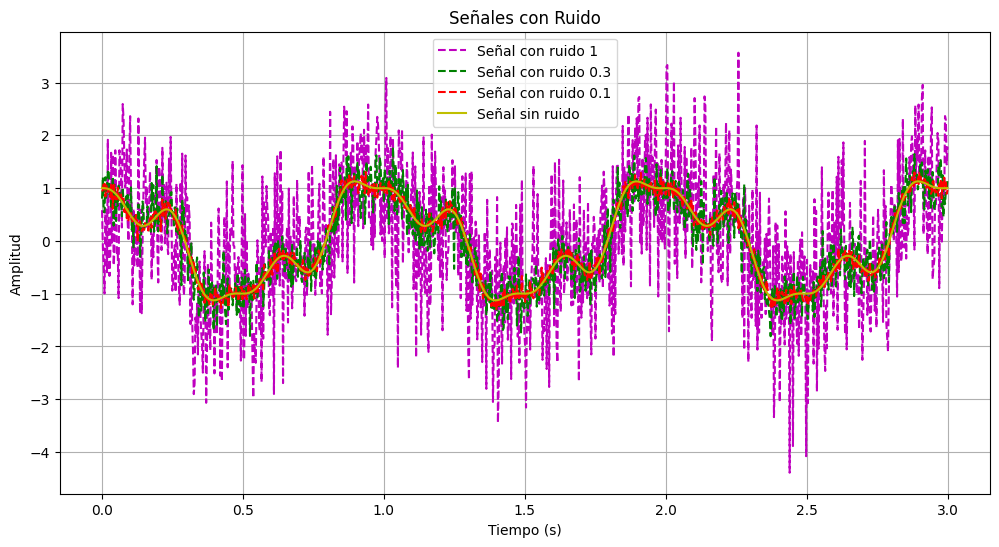

In [ ]:
#Verificación de las señales con ruido blanco gaussiano y la señal original
plt.figure(figsize=(12,6))
plt.title('Señales con Ruido')
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.plot(t,M[680], 'm',label = 'Señal con ruido 1', linestyle = '--') #Ruido 1 = 680 a 1019
plt.plot(t,M[340], 'g', label = 'Señal con ruido 0.3', linestyle = '--') #Ruido 0.3 = 340 a 679
plt.plot(t,M[0],'r', label = 'Señal con ruido 0.1', linestyle = '--')  #Ruido 0.1 = 0 a 339
plt.plot(t,xt, 'y', label = 'Señal sin ruido', linewidth=1.5)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
def calculate_psd(signals,fs,nperseg):
    fr,PSD = signal.welch(signals,fs=fs,nperseg=nperseg)
    return fr,PSD

fr, Wt = calculate_psd(xt,fs,N) #PSD Señal original
fr, Wr = calculate_psd(M,fs,N) #PSD Matriz con señales ruidosas

<ipython-input-69-cedfe76fbd97>:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10**-8,0)


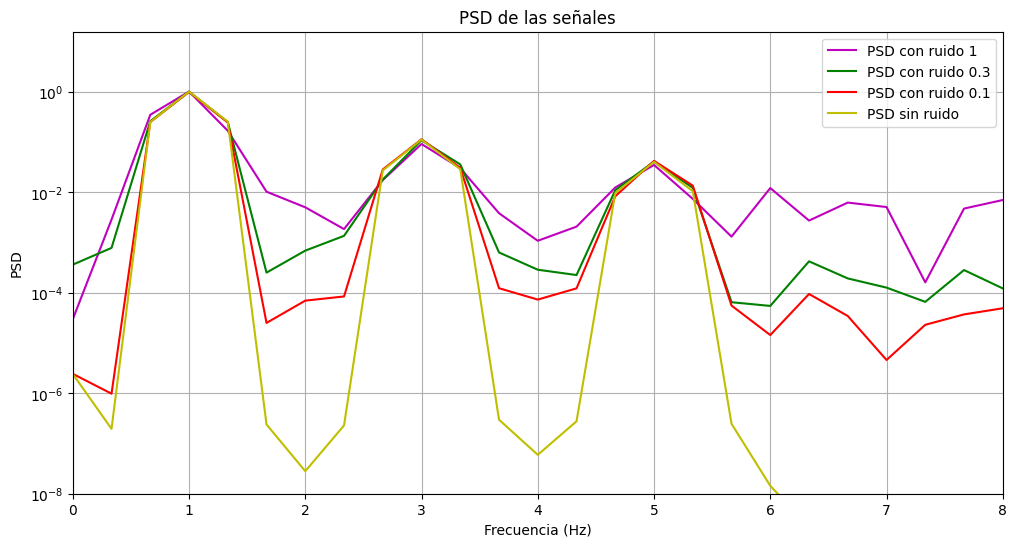

In [ ]:
#Visualización del PSD de las señales (original y con ruido)
plt.figure(figsize=(12,6))
plt.title('PSD de las señales')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD')
plt.semilogy(fr,Wr[680],'m', label="PSD con ruido 1")
plt.semilogy(fr,Wr[340],'g', label="PSD con ruido 0.3")
plt.semilogy(fr,Wr[0],'r', label="PSD con ruido 0.1")
plt.semilogy(fr,Wt, 'y', label="PSD sin ruido")
plt.xlim(0,8)
plt.ylim(10**-8,0)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#dimensiones de los datos(importante para la red) generar varias señales para el entrenamiento
print(len(xt))     #todas las señales tienen 1024 puntos (entrada de la red)
print(len(Wt)) #todos los psd calculados tienen 513 puntos (salida de la red)

1024
513


# Modelo de la red MLP para predecir PSD

In [ ]:
#Preparación de datos
#Separación de datos
x_train, x_test, y_train, y_test = train_test_split(M, Wr, test_size=0.3, random_state=50)

#Funciones de escalamiento separados en entradas y salidas
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

#Escalado de las entradas
x_train = scaler_x.fit_transform(x_train)
y_train = scaler_y.fit_transform(y_train)

#Escalado de las salidas
x_test = scaler_x.transform(x_test)
y_test = scaler_y.transform(y_test)

In [ ]:
model=Sequential()
model.add(Dense(512,activation='relu',input_dim=N))
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(513,activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.0001),loss='mse',metrics=['accuracy'])

history=model.fit(x_train,y_train,epochs=20,batch_size=16, validation_split=0.2)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.0000e+00 - loss: 0.0301 - val_accuracy: 0.0000e+00 - val_loss: 0.0186
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 9.2406e-04 - loss: 0.0200 - val_accuracy: 0.0350 - val_loss: 0.0170
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0262 - loss: 0.0185 - val_accuracy: 0.0420 - val_loss: 0.0150
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.0495 - loss: 0.0171 - val_accuracy: 0.0559 - val_loss: 0.0133
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0355 - loss: 0.0152 - val_accuracy: 0.0420 - val_loss: 0.0121
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.0684 - loss: 0.0133 - val_accuracy: 0.0350 - val_loss: 0.0112
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1618 - loss: 0.0122 - val_accuracy: 0.0629 - val_loss: 0.0114
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1012 - loss: 0.0117 - val_accuracy: 0.1538 - 

# Loss y Accuracy

Text(0.5, 1.0, 'Model Loss')

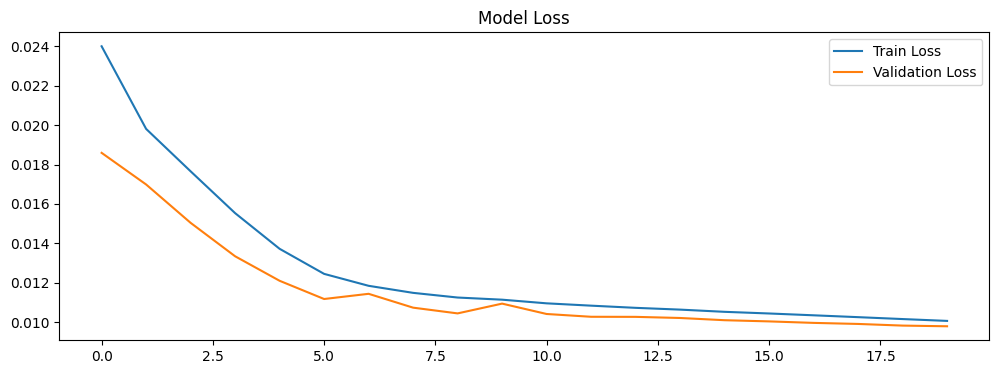

In [ ]:
#Visualización perdida del entrenamiento y la validación
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')

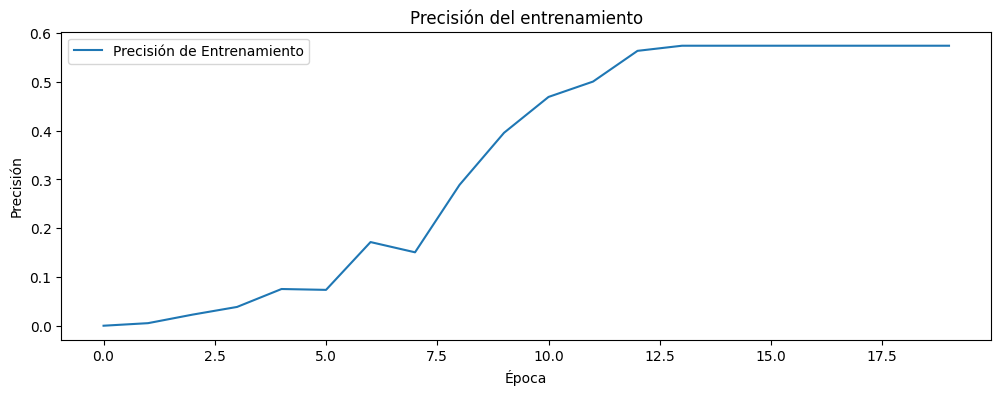

In [ ]:
#Visualización de la precisión del modelo
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'])
plt.title('Precisión del entrenamiento')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Precisión de Entrenamiento'])
plt.show()

# Evaluación del modelo

Revisión del procentaje de precisión alcanzado con el entrenamiento, visualización del resultado de psd predicho para cada nivel de ruido y comparación con el calculado a la señal original (welch)

In [ ]:
#Porcentaje de precisión y perdida del modelo
test_loss, test_acc = model.evaluate(x_test, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5329 - loss: 0.0110 


In [ ]:
#Generación de la matriz con los resultados predichos con el modelo
y_pred = model.predict(x_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [ ]:
#Aplicación de transformada inversa para desnormalizar los resultados
y1 = scaler_y.inverse_transform(y_pred)

<ipython-input-108-a80886dd0607>:11: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(10**-8,0)


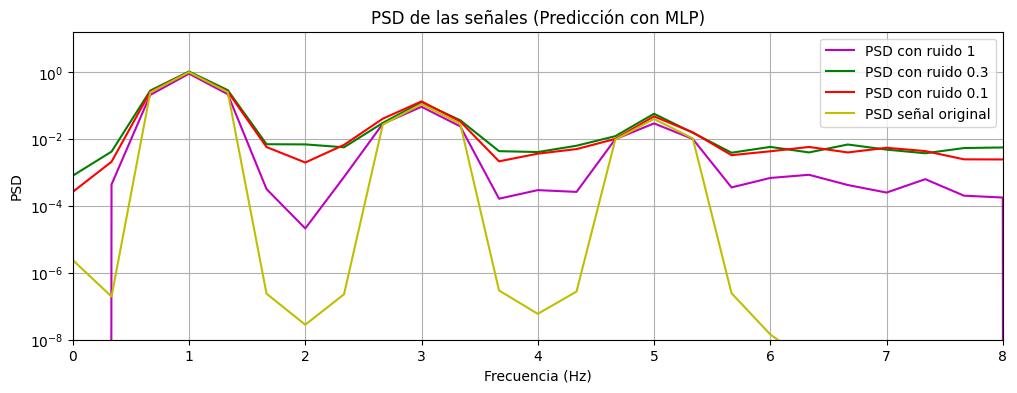

In [ ]:
#Visualización del PSD de las señales (original y con ruido)
plt.figure(figsize=(12,4))
plt.title('PSD de las señales (Predicción con MLP)')
plt.xlabel('Frecuencia (Hz)')
plt.ylabel('PSD')
plt.semilogy(fr,y1[204],'m', label="PSD con ruido 1")
plt.semilogy(fr,y1[102],'g', label="PSD con ruido 0.3")
plt.semilogy(fr,y1[0],'r', label="PSD con ruido 0.1")
plt.semilogy(fr,Wt, 'y', label="PSD señal original")
plt.xlim(0,8)
plt.ylim(10**-8,0)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
#Calculo de error (en L1 y L2) entre el PSD de la señal original y el PSD predicho
dif= Wt - y1
def calculate_error(difference, p):
    return np.linalg.norm(difference, ord=p)

# Calculate the error for p=1 and p=2
error_p1 = calculate_error(dif, p=1)
error_p2 = calculate_error(dif, p=2)

print(f'Error con p=1: {error_p1}') #Norma L1
print(f'Error con p=2: {error_p2}') #Norma L2

Error con p=1: 23.72504162269416
Error con p=2: 1.7400401984565619


# Reconstrucción de la señal

In [ ]:
def reconstruct_signal(psd, N):
    # Asegurarse de que el PSD tenga la longitud correcta
    if len(psd) < N // 2 + 1:
        psd = np.pad(psd, (0, N // 2 + 1 - len(psd)), mode='constant')
    elif len(psd) > N // 2 + 1:
        psd = psd[:N // 2 + 1]

    # Crear el espectro completo (simétrico)
    full_psd = np.concatenate([psd, psd[-2:0:-1]])
    full_psd = np.clip(full_psd, a_min=0, a_max=None)  # Asegurarse de que no haya valores negativos

    # Convertir PSD a magnitudes
    magnitudes = np.sqrt(full_psd)

    # Generar fases aleatorias
    phases = np.random.uniform(0, 2*np.pi, len(magnitudes))

    # Crear el espectro complejo
    spectrum = magnitudes * np.exp(1j * phases)

    # Realizar la IFFT para obtener la señal en el dominio del tiempo
    reconstructed = np.fft.ifft(spectrum).real

    # Normalizar la señal reconstruida
    reconstructed = reconstructed - np.mean(reconstructed)
    reconstructed = reconstructed / np.std(reconstructed)

    return reconstructed

# Usar la función para reconstruir la señal
reconstructed_signal_real1 = reconstruct_signal(y1[0], N) #Ruido 0.1
reconstructed_signal_real2 = reconstruct_signal(y1[102], N) #Ruido 0.3
reconstructed_signal_real3 = reconstruct_signal(y1[204], N) #Ruido 1

# Normalizar la señal original para una comparación justa
xt_normalized = (xt - np.mean(xt)) / np.std(xt)

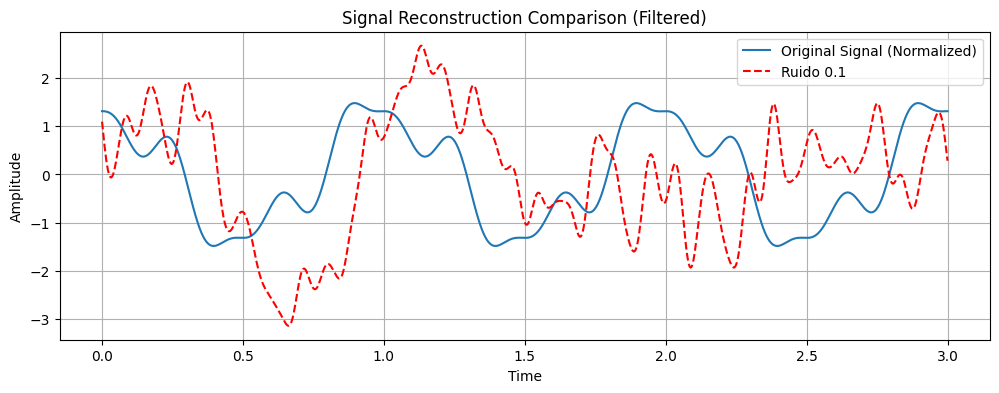

In [ ]:
#Filtro pasabajos para suavizar el ruido
def butter_lowpass_filter(data, cutoff, fs, order=4):
    nyq = 400  # Frecuencia de Nyquist
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

# Usar la función de filtro de paso bajo después de reconstruir la señal
cutoff_freq = 30  # Frecuencia de corte para el filtro de paso bajo
reconstructed_signal_real_filtered1 = butter_lowpass_filter(reconstructed_signal_real1, cutoff=cutoff_freq, fs=T)*2
reconstructed_signal_real_filtered2 = butter_lowpass_filter(reconstructed_signal_real2, cutoff=cutoff_freq, fs=T)*2
reconstructed_signal_real_filtered3 = butter_lowpass_filter(reconstructed_signal_real3, cutoff=cutoff_freq, fs=T)*2

# Graficar la comparación con la señal filtrada
plt.figure(figsize=(12, 4))
plt.plot(t, xt_normalized, label='Original Signal (Normalized)')
plt.plot(t, reconstructed_signal_real_filtered1, 'r',label='Ruido 0.1', linestyle="--")
#plt.plot(t, reconstructed_signal_real_filtered2, 'g',label='Ruido 0.3',linestyle="--")
#plt.plot(t, reconstructed_signal_real_filtered3, 'm',label='Ruido 1',linestyle="--")
plt.title('Signal Reconstruction Comparison (Filtered)')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

#Implementación del umbral

In [ ]:
#Encontrar el primer armonico del PSD
def find_first_harmonic(fr, PSD):
    peak_index = np.argmax(PSD[1:]) + 1  # Ignorar DC component en fr[0]
    frequency = fr[peak_index]
    power = PSD[peak_index]
    return frequency, power

In [ ]:
#Calcular Umbral utilizando estadisticas descriptivas
def calculate_adaptive_threshold(psd_matrix, factor=2):
    harmonics = np.array([find_first_harmonic(fr, psd)[1] for psd in psd_matrix])
    Q1, Q2 = np.percentile(harmonics, [25, 75])
    IQR = Q2 - Q1
    threshold = Q2 + factor * IQR  # Umbral basado en outliers (adaptativo)
    return threshold

In [ ]:
#Aplicar umbral para PSD predichos
threshold = calculate_adaptive_threshold(y1, factor=0.3)  # Factor menor aumenta sensibilidad, mayor la disminuye

def apply_threshold(psd_matrix, threshold):
    filtered_psds = []
    for psd in psd_matrix:
        _, power = find_first_harmonic(fr, psd)
        if power > threshold:
            filtered_psds.append(psd)
    return np.array(filtered_psds)

In [ ]:
#Visualización de X en el primer armonico
def plot_psd_with_first_harmonic(fr, psd, threshold, title=""):
    freq, power = find_first_harmonic(fr, psd)
    plt.figure(figsize=(12, 4))
    plt.title("Umbral PSD Primer Armonico")
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('PSD')
    plt.semilogy(fr, psd, 'b', label="PSD")
    plt.scatter([freq], [power], color='r', label=f'Primer armónico: {freq:.2f} Hz, Potencia: {power:}')
    plt.axhline(y=threshold, color='g', linestyle='--', label=f'Umbral: {threshold:}')
    plt.xlim(0, 15)
    plt.ylim(10**-5,10**2)
    plt.legend()
    plt.grid(True)
    plt.show()

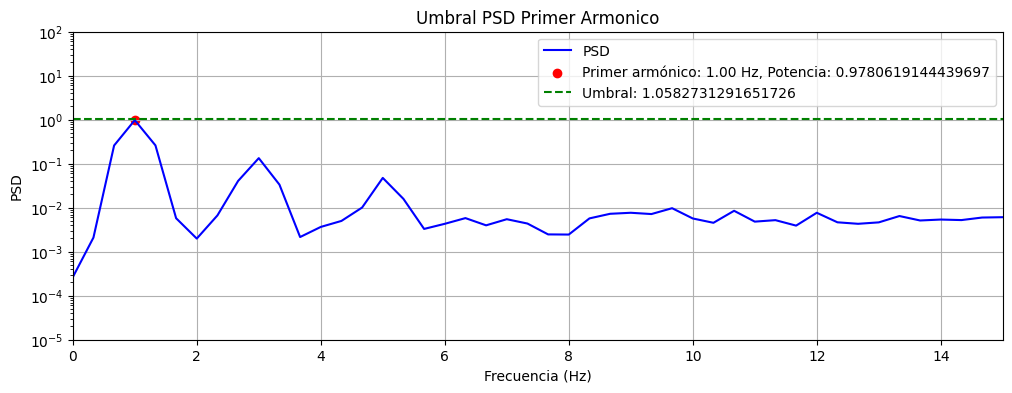

In [ ]:
V = plot_psd_with_first_harmonic(fr,y1[0],threshold) #Se puede graficar cualquier PSD de 0 a 305